In [2395]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize
import scipy.signal
import sigmf
from data_path import data_path

plt.rcParams['font.size'] = 14
plt.rcParams['figure.facecolor'] = 'w'
plt.rcParams['figure.figsize'] = (10, 5)

In [2396]:
# handle = sigmf.sigmffile.fromfile(data_path + '/763MHz_15360KSPS.sigmf-data')
# delta_f = 450e3
# f = 763e6
# mu = 0
# apply_fine_CFO = 1

handle = sigmf.sigmffile.fromfile(data_path + '/3627MHz_30720KSPS.sigmf-data')
delta_f = -600e3
f = 3672e6
mu = 1
apply_fine_CFO = 1

# handle = sigmf.sigmffile.fromfile('30720KSPS_dl_signal.sigmf-data')
# delta_f = 0
# f = 1
# mu = 0
# apply_fine_CFO = 0  # why does fine_CFO fail for perfect input file??

x_orig = handle.read_samples()
x_orig /= max(x_orig.real.max(), x_orig.imag.max()) # scale max amplitude to 1
fs = handle.get_global_field(sigmf.SigMFFile.SAMPLE_RATE_KEY)



In [2397]:
# The units here are samples
SCS = 15e3 * 2**mu
Tu = int(fs/SCS) # useful time of a symbol
cp1 = int(5.2e-6*fs * 2**(-mu))
cp2 = int(4.7e-6*fs * 2**(-mu))

In [2398]:
# defined in 3GPP TS 38.211 version 16.3.0 Release 16
# verified with nrPSS() in Matlab
def calc_PSS(N_id_2):
    n = 127
    x = np.zeros(n, 'int32')    # m-sequence
    x[0:7] = np.array([0, 1, 1, 0, 1, 1, 1])
    for i in np.arange(0, 127 - 7):
        x[i+7] = (x[i + 4] + x[i]) % 2
    d_PSS = np.zeros(n, 'int32')
    for n in np.arange(0, 127):
        m = (n + 43*N_id_2) % 127  # offset based on N_id_2
        d_PSS[n] = 1 - 2*x[m]  # BPSK modulation
    return d_PSS

In [2399]:
PSS = [calc_PSS(0), calc_PSS(1), calc_PSS(2)]
subcarriers_ss = slice(Tu//2 - 1 - 63, Tu//2 - 1 + 64)
PSS_time = np.empty((3, Tu), 'complex')
PSS_time_coarse = np.empty((3, Tu), 'complex')
for j in range(PSS_time.shape[0]):
    PSS_all = np.zeros(Tu, 'complex')
    PSS_all[subcarriers_ss] = PSS[j]
    PSS_time[j] = np.fft.ifft(np.fft.fftshift(PSS_all))
    PSS_time_coarse[j] = PSS_time[j] * np.exp(1j*(2*np.pi*delta_f/fs*np.arange(PSS_time.shape[1])))  


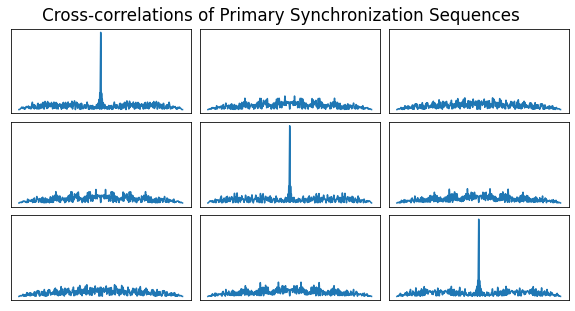

In [2400]:
fig, axs = plt.subplots(3, 3, facecolor='w', sharex=True, sharey=True)
for j in range(3):
    for k in range(3):
        axs[j, k].plot(np.abs(np.correlate(PSS_time[j], PSS_time[k], mode='full')))
        axs[j, k].set_xticks([])
        axs[j, k].set_yticks([])
plt.suptitle('Cross-correlations of Primary Synchronization Sequences', y=0.94)
plt.subplots_adjust(wspace=0.05, hspace=0.1)

In [2401]:
PSS_corr = np.empty((3, int(25e-3 * fs)), 'complex') # do cross correlation for 25 ms, bcs SSB comes every 20 ms
if False:
    for j in range(PSS_corr.shape[1]):
        PSS_corr[:, j] = np.sum(x_orig[j:][:Tu] * np.conj(PSS_time_coarse), axis=1)
else:
    # this is much faster!
    for j in range(PSS_time_coarse.shape[0]):
        PSS_corr[j] = scipy.signal.correlate(x_orig[:PSS_corr.shape[1]+Tu-1], PSS_time_coarse[j], 'valid')
t_corr = np.arange(PSS_corr.shape[1])/fs

Text(0.5, 0.93, 'Cross-correlation of signal with Primary Synchronization Sequences')

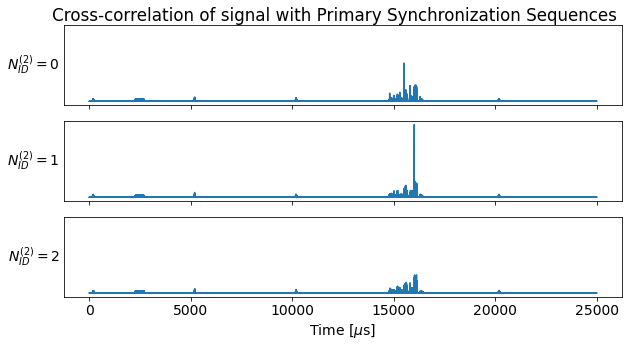

In [2402]:
fig, axs = plt.subplots(3, 1, facecolor='w', sharex=True, sharey=True)
for j, ax in enumerate(axs.ravel(order='F')):
    ax.plot(t_corr*1e6, np.abs(PSS_corr[j]))
    ax.set_yticks([])
    ax.set_ylabel(f'$N_{{ID}}^{{(2)}} = {j}$', rotation=0,
        horizontalalignment='right', verticalalignment='center')
axs[-1].set_xlabel('Time [$\mu$s]')
plt.suptitle('Cross-correlation of signal with Primary Synchronization Sequences', y=0.93)

In [2403]:
idx, a0 = np.unravel_index(np.argmax(np.abs(PSS_corr)), PSS_corr.shape)
N_id_2 = idx
N_id_2, idx, a0

(1, 1, 492020)

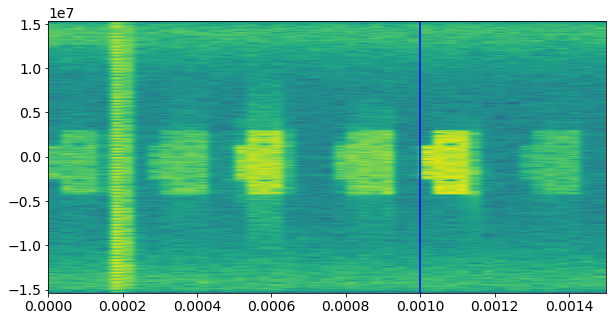

In [2404]:
nFFT = Tu
x0 = max(0, a0 - 1E-3*fs) # display 1 ms before detected PSS
plt.specgram(x_orig[int(x0):int(x0)+nFFT*45], Fs=fs, NFFT=nFFT, noverlap=0)
#plt.specgram(x_orig, Fs=fs, NFFT=nFFT, noverlap=0)
a0_time = (a0-x0)/fs
plt.axvline(x = a0_time, color = 'b', label = 'axvline - full height')

In [2474]:
cfo = delta_f
x_coarse =  x_orig[a0-cp2:] * np.exp(-1j*2*np.pi*cfo/fs*(np.arange(len(x_orig[a0-cp2:]))))
# fine CFO
if True:
    # this is sometimes more accurate than SSS based CFO correction
    cfo_norm = np.angle(np.dot(x_coarse[:cp2], np.conj(x_coarse[Tu:][:cp2]))) / Tu
    delta_phi = cfo_norm / (2*np.pi) * fs
    print(f'cp based fine CFO is {delta_phi} Hz')
if False:
    C0 =  np.sum(x_coarse[cp2:][:Tu//2] * np.conjugate(PSS_time[N_id_2][:Tu//2]))
    C1 = np.sum(x_coarse[cp2:][Tu//2:Tu] * np.conjugate(PSS_time[N_id_2][-Tu//2:]))
    cfo_hz_max = fs/(Tu/2)
    delta_phi = np.angle(C0*np.conjugate(C1)) / (2*np.pi) * cfo_hz_max - 10
    print(f"PSS based fine CFO {delta_phi:.03f} Hz")
if True:
    x = x_coarse * np.exp(1j*2*np.pi * delta_phi/fs * (np.arange(len(x_coarse))))
    cfo -= delta_phi
else:
    x = x_coarse

cp based fine CFO is -1102.7091375583655 Hz


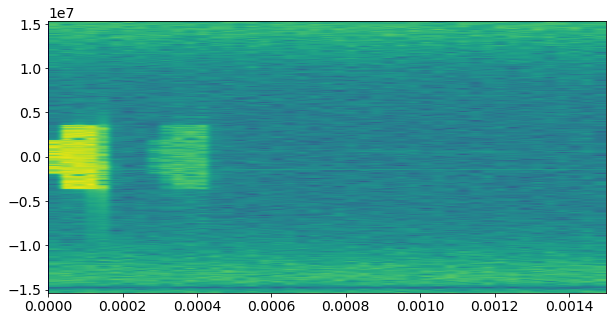

In [2475]:
nFFT = Tu
x0 = a0 # display starting with detected PSS
plt.specgram(x_coarse[:nFFT*45], Fs=fs, NFFT=nFFT, noverlap=0)
#plt.specgram(x_orig, Fs=fs, NFFT=nFFT, noverlap=0)
a0_time = (a0-x0)/fs
plt.axvline(x = a0_time, color = 'b', label = 'axvline - full height')

In [2504]:
def calc_delay(sym1, sym2):
    lse = sym1 * sym2
    sum = 0
    for i in np.arange(1, len(lse)):
        sum += lse[i]*np.conj(lse[i-1])
    return np.angle(sum) / (2*np.pi)

def calc_phase(sym1, sym2):
    if False:
        if np.abs(np.angle(sym1[0] * np.conj(sym2[0]))) > 3/4*np.pi:
            # prevent wrap around errors if phase is near +- pi
            return np.average(np.angle(sym1 * np.conj(sym2) * np.exp(1j*np.pi/2))) - np.pi/2 
        else:
            return np.average(np.angle(sym1 * np.conj(sym2)))
    else:
        # this is more robust against phase wrap around
        return np.angle(np.dot(sym1, sym2))



SSB 3 skipping -1 samples
SSB 9 skipping -1 samples
SSB 13 skipping -233 samples
SSB 14 skipping -415 samples
SSB 15 skipping -8 samples
SSB 16 skipping 174 samples
SSB 17 skipping -463 samples
SSB 18 skipping -452 samples
SSB 19 skipping -49 samples
SSB 20 skipping -78 samples
SSB 21 skipping 464 samples
SSB 22 skipping 322 samples
SSB 23 skipping -346 samples
SSB 24 skipping -154 samples
SSB 25 skipping 346 samples
SSB 26 skipping -342 samples
SSB 27 skipping -234 samples
SSB 28 skipping -125 samples
SSB 29 skipping 347 samples
SSB 30 skipping -193 samples
SSB 31 skipping -67 samples
SSB 32 skipping 165 samples
SSB 33 skipping 245 samples
SSB 34 skipping -504 samples
SSB 35 skipping -39 samples
SSB 36 skipping 22 samples
SSB 37 skipping 44 samples
SSB 38 skipping 257 samples
SSB 39 skipping 399 samples
SSB 40 skipping 465 samples
SSB 41 skipping -448 samples
SSB 42 skipping 144 samples
SSB 43 skipping -165 samples
SSB 44 skipping -241 samples
SSB 45 skipping 249 samples
SSB 46 skippi

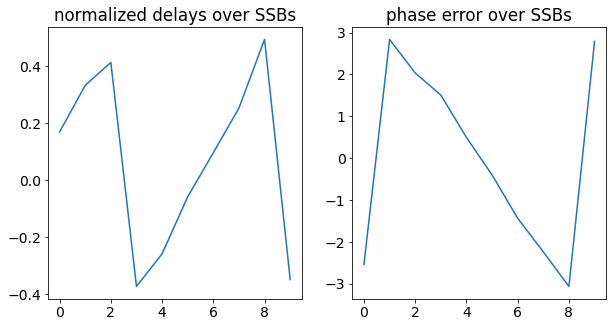

In [2505]:
n_SSBs = x.size // int(fs * 20e-3)
syms_pss = np.empty((n_SSBs, 127), 'complex')
syms_sss = np.empty((n_SSBs, 127), 'complex')
offset_SSS = (Tu + (cp2+Tu) + cp2)
no_dc = np.concatenate((np.arange(63), np.arange(64, 127)))
if False:
    symbol_start = cp2
else:
    # like srsRAN
    symbol_start = cp2//2
t_offset = symbol_start
delays = np.empty(n_SSBs)
phases = np.empty(n_SSBs)
correct_delay = True
correct_phase = True
for j in range(n_SSBs):
    symbol_pss_time = x[t_offset:][:Tu]
    symbol_sss_time = x[t_offset + offset_SSS:][:Tu]
    symbol_pss = np.fft.fftshift(np.fft.fft(symbol_pss_time))[subcarriers_ss]
    symbol_sss = np.fft.fftshift(np.fft.fft(symbol_sss_time))[subcarriers_ss]    
    # this cp delay compensation is absolutely needed if the symbol starts with some of the cp at the beginning
    symbol_pss *= np.exp(1j*2*np.pi * (cp2 - symbol_start)/Tu * (np.arange(len(symbol_pss))))
    symbol_sss *= np.exp(1j*2*np.pi * (cp2 - symbol_start)/Tu * (np.arange(len(symbol_sss))))
    
    if correct_delay:
        # delay compensation (aka SFO or STO compensation) like in srsRAN in method ssb_measure()
        # sampling frequency offset appears in the constellation diagramm as a growing smear over time
        delay_norm = calc_delay(symbol_pss, PSS[N_id_2])
        delays[j] = delay_norm

        #print(f"PSS based delay for SSB nr {j} is {delay_norm/SCS*1e6:.06f} us (srsRAN method)")        
        symbol_pss *= np.exp(-1j*2*np.pi * delay_norm * (np.arange(len(symbol_pss))))
        symbol_sss *= np.exp(-1j*2*np.pi * delay_norm * (np.arange(len(symbol_pss))))
        skip_samples = -int(np.round(delay_norm / SCS * fs))
        if np.abs(skip_samples) > 0 and t_offset+skip_samples > 0:
            # it is not possible to shift more than 1/fs by doing multiplication with e^jwt
            t_offset += skip_samples
            if True:
                print(f'SSB {j} skipping {skip_samples} samples')
                symbol_pss = np.fft.fftshift(np.fft.fft(x[t_offset:][:Tu]))[subcarriers_ss]
                symbol_sss = np.fft.fftshift(np.fft.fft(x[t_offset + offset_SSS:][:Tu]))[subcarriers_ss]
                # cp delay compensation
                symbol_pss *= np.exp(1j*2*np.pi * (cp2 - symbol_start)/Tu * (np.arange(len(symbol_pss))))
                symbol_sss *= np.exp(1j*2*np.pi * (cp2 - symbol_start)/Tu *(np.arange(len(symbol_sss))))

                delay_norm = calc_delay(symbol_pss, PSS[N_id_2])
                delays[j] = delay_norm
                
                symbol_pss *= np.exp(-1j*2*np.pi*delay_norm*(np.arange(len(symbol_pss))))
                symbol_sss *= np.exp(-1j*2*np.pi*delay_norm*(np.arange(len(symbol_pss))))

    if correct_phase:
        phase = calc_phase(symbol_pss, PSS[N_id_2])
        phases[j] = phase
        symbol_pss *= np.exp(-1j * phase)
        symbol_sss *= np.exp(-1j * (phase + 2*np.pi*cfo/fs*offset_SSS))

    syms_pss[j] = symbol_pss
    syms_pss[j] /= max(syms_pss[j].real.max(), syms_pss[j].imag.max())
    syms_sss[j] = symbol_sss
    syms_sss[j] /= max(syms_sss[j].real.max(), syms_sss[j].imag.max())
    t_offset += int(round(20e-3 * fs))
fig, axs = plt.subplots(1, 2, figsize=(10, 5), facecolor='w', sharex=True, sharey=False)    
#fig.suptitle('normalized delays over SSBs', y=0.95)
axs[0].set_title('normalized delays over SSBs')
axs[0].plot(delays[0:10]/SCS*fs)
axs[1].set_title('phase error over SSBs')
axs[1].plot(phases[0:10])


Text(0.5, 0.95, 'PSS symbols')

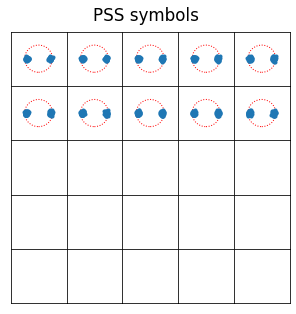

In [2506]:
n = int(min(int(np.sqrt(n_SSBs)),5))
fig, axs = plt.subplots(n, n, figsize=(n, n), facecolor='w', sharex=True, sharey=True)
for j in range(2):
    for k in range(n):
        if (n == 1):
            ax = axs
        else:
            ax = axs[j, k]
        idx = n * j + k
        syms = syms_pss[idx]
        ax.plot(syms.real, syms.imag, '.')
        ax.add_patch(plt.Circle((0, 0), 1, color='red', fill=False, linewidth=1, linestyle=':'))
        ax.set_xlim((-2, 2))
        ax.set_ylim((-2, 2))
        ax.set_xticks([])
        ax.set_yticks([])
        
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('PSS symbols', y=0.95)

Text(0.5, 0.95, 'SSS symbol')

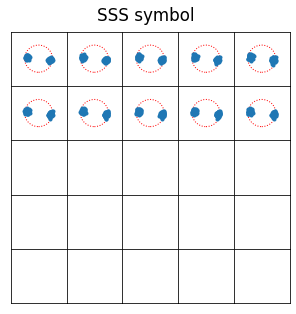

In [2507]:
n = int(min(int(np.sqrt(n_SSBs)),5))
fig, axs = plt.subplots(n, n, figsize=(n, n), facecolor='w', sharex=True, sharey=True)
for j in range(2):
    for k in range(n):
        if (n == 1):
            ax = axs
        else:
            ax = axs[j, k]
        idx = n * j + k
        syms = syms_sss[idx]
        ax.plot(syms.real, syms.imag, '.')
        ax.add_patch(plt.Circle((0, 0), 1, color='red', fill=False, linewidth=1, linestyle=':'))
        ax.set_xlim((-2, 2))
        ax.set_ylim((-2, 2))
        ax.set_xticks([])
        ax.set_yticks([])
        
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('SSS symbol', y=0.95)

In [2508]:
# defined in 3GPP TS 38.211 version 16.3.0 Release 16
def calc_m_seq_0():
    n = 127
    x = np.zeros(n, 'int32')    # m-sequence    
    x[0:7] = np.array([1, 0, 0, 0, 0, 0, 0])
    for i in np.arange(0, n - 7):
        x[i+7] = (x[i + 4] + x[i]) % 2    
    return x

def calc_m_seq_1():
    n = 127
    x = np.zeros(n, 'int32')    # m-sequence
    x[0:7] = np.array([1, 0, 0, 0, 0, 0, 0])
    for i in np.arange(0, n - 7):
        x[i+7] = (x[i + 1] + x[i]) % 2        
    return x

def gold(N_id_1, N_id_2):
    n = 127
    x_0 = calc_m_seq_0()
    x_1 = calc_m_seq_1()
    d_SSS = np.zeros(n, 'int32')    
    m_0 = 15*int((N_id_1/112)) + 5*N_id_2
    m_1 = N_id_1 % 112
    for n in np.arange(0, 127):
        d_SSS[n] = (1 - 2*x_0[(n + m_0) % 127]) * (1 - 2*x_1[(n + m_1) % 127])
    return d_SSS

SSS = np.zeros((336, 127))
for i in range(336):
    SSS[i, :] = gold(i, N_id_2)

N_id = 967 (N_id_1 = 322, N_id_2 = 1)


<function matplotlib.pyplot.show(close=None, block=None)>

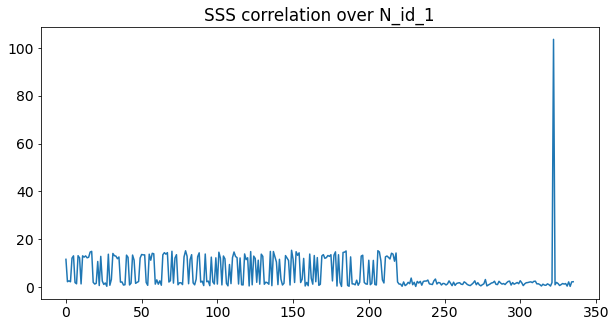

In [2509]:
#SSS_corr = np.sum(x_orig[a0 + round(5e-3 * fs * j * samp_rate_error):][:Tu] * np.conjugate(SSS), axis=1)
#t_corr = np.arange(SSS_corr.shape[1])/fs
SSS_corr = np.empty(336, 'complex')
for i in range(SSS_corr.shape[0]):
    SSS_corr[i] = np.sum(syms_sss[0] * SSS[i], axis=0)
N_id_1 = np.argmax(np.abs(SSS_corr))
N_id = 3*N_id_1 + N_id_2
print(f'N_id = {N_id} (N_id_1 = {N_id_1}, N_id_2 = {N_id_2})')
plt.plot(np.abs(SSS_corr))
plt.title('SSS correlation over N_id_1')
plt.show

In [2510]:
fig, axs = plt.subplots(n, n, figsize=(n, n), facecolor='w', sharex=True, sharey=True)
for j in range(2):
    for k in range(n):
        if (n == 1):
            ax = axs
        else:
            ax = axs[j, k]
        idx = n * j + k
        syms = syms_pss[idx] / PSS[N_id_2]
        ax.plot(syms.real, syms.imag, '.')
        ax.add_patch(plt.Circle((0, 0), 1, color='red', fill=False, linewidth=1, linestyle=':'))
        ax.set_xlim((-2, 2))
        ax.set_ylim((-2, 2))
        ax.set_xticks([])
        ax.set_yticks([])
        
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('PSS symbols wiped', y=0.95)


Text(0.5, 0.95, 'PSS symbols wiped')

Text(0.5, 0.95, 'SSS symbols wiped')

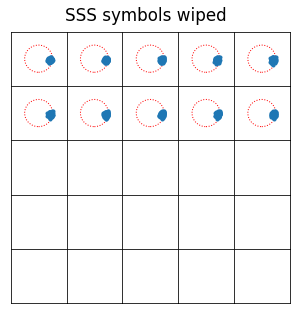

In [ ]:
fig, axs = plt.subplots(n, n, figsize=(n, n), facecolor='w', sharex=True, sharey=True)
for j in range(2):
    for k in range(n):
        if (n == 1):
            ax = axs
        else:
            ax = axs[j, k]
        idx = n * j + k
        syms = syms_sss[idx] / SSS[N_id_1]
        ax.plot(syms.real, syms.imag, '.')
        ax.add_patch(plt.Circle((0, 0), 1, color='red', fill=False, linewidth=1, linestyle=':'))
        ax.set_xlim((-2, 2))
        ax.set_ylim((-2, 2))
        ax.set_xticks([])
        ax.set_yticks([])
        
fig.subplots_adjust(hspace=0, wspace=0)
fig.suptitle('SSS symbols wiped', y=0.95)

In [ ]:
# residual CFO estimation in frequency domain
for i in range(10):
    if True:
        # this is robust against wrap around
        corr1 = np.dot(syms_pss[i], PSS[N_id_2])
        corr2 = np.dot(syms_sss[i], SSS[N_id_1])
        pss_sss_distance_s = 2*(Tu+cp2)/fs
        cfo_hz = np.angle(corr1*np.conj(corr2)) / pss_sss_distance_s / (2*np.pi)
        print(f'residual CFO for SSB {i} is {cfo_hz} Hz')
    if False:
        # this is not robust against wrap around
        np.angle(syms_pss[0] * np.conj(PSS[N_id_2]))
        phase1 = np.average(np.angle(syms_pss[i] * np.conj(PSS[N_id_2])))
        phase2 = np.average(np.angle(syms_sss[i] * np.conj(SSS[N_id_1])))
        pss_sss_distance_s = 2*(Tu+cp2)/fs
        print(f'residual CFO for SSB {i} is {(phase1 - phase2) / pss_sss_distance_s / (2*np.pi)} Hz')

residual CFO for SSB 0 is 267.3438156492455
residual CFO for SSB 1 is 279.06898737556014
residual CFO for SSB 2 is 265.6870939525985
residual CFO for SSB 3 is 275.79277173317945
residual CFO for SSB 4 is 290.34597838742445
residual CFO for SSB 5 is 278.78064019584025
residual CFO for SSB 6 is 310.3520870901252
residual CFO for SSB 7 is 278.9447141330858
residual CFO for SSB 8 is 280.7414216625842
residual CFO for SSB 9 is 286.97445487865224
